This tutorial gives an overview of some of validation tools available when
using the Tidegauge objects in COAsT.

This includes:
- creating tidegauge objects
    - reading in tidegauge data
    - creating tidegauge object from gridded simulation data
- basic plotting
    - on maps and timeseries
- analysis
    - harmonic analysis and calculation of non-tidal residual
    - doodsonX0 tidal filtering
    - threshold statistics
    - error calculation: mean errors, mean absolute error (MAE), mean square error (MSE)
    

### Import necessary libraries


In [1]:
import xarray as xr
import numpy as np
import coast
import datetime
import matplotlib.pyplot as plt

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast


### Define paths


In [43]:
fn_dom = "<PATH_TO_NEMO_DOMAIN>"
fn_dat = "<PATH_TO_NEMO_DATA>"
fn_config = "<PATH_TO_CONFIG.json>"
fn_tg = "<PATH_TO_TIDEGAUGE_NETCDF>"  # This should already be processed, on the same time dimension

# Change this to 0 to not use default files.
if 1:
    #print(f"Use default files")
    dir = "./example_files/"
    fn_dom = dir + "coast_example_nemo_domain.nc"
    fn_dat = dir + "coast_example_nemo_data.nc"
    fn_config = "./config/example_nemo_grid_t.json"
    fn_tidegauge = dir + "tide_gauges/lowestoft-p024-uk-bodc"
    fn_tidegauge_bodc = dir + "tide_gauges/LIV2010.txt"
    fn_tg = dir + "tide_gauges/coast_example_tidegauges.nc"  # These are a collection (xr.DataSet) of tidegauge observations. Created for this demonstration, they are synthetic.

### Reading data

We can create our empty tidegauge object:

In [3]:
tidegauge = coast.Tidegauge()

Tidegauge object at 0x7fd50df9da00 initialised


The `Tidegauge` class contains multiple methods for reading different typical
tidegauge formats. This includes reading from the GESLA and BODC databases.
To read a gesla file between two dates, we can use:

In [5]:
date0 = datetime.datetime(2007,1,10)
date1 = datetime.datetime(2007,1,12)
tidegauge.read_gesla(fn_tidegauge, date_start = date0, date_end = date1)

A Tidegauge object is a type of Timeseries object, so it has the form:

In [6]:
tidegauge.dataset

<xarray.Dataset>
Dimensions:    (id_dim: 1, t_dim: 193)
Coordinates:
    time       (t_dim) datetime64[ns] 2007-01-10 ... 2007-01-12
    longitude  (id_dim) float64 1.751
    latitude   (id_dim) float64 52.47
    site_name  (id_dim) <U9 'Lowestoft'
Dimensions without coordinates: id_dim, t_dim
Data variables:
    ssh        (id_dim, t_dim) float64 2.818 2.823 2.871 ... 3.214 3.257 3.371
    qc_flags   (id_dim, t_dim) int64 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1

You can do the same for BODC data:

In [42]:
date0 = np.datetime64("2020-10-11 07:59")
date1 = np.datetime64("2020-10-20 20:21")
tidegauge.read_bodc(fn_tidegauge_bodc, date0, date1)
tidegauge.dataset

<xarray.Dataset>
Dimensions:    (id_dim: 1, t_dim: 914)
Coordinates:
    time       (t_dim) datetime64[ns] 2020-10-11T08:00:00 ... 2020-10-20T20:1...
    longitude  (id_dim) float64 -3.018
    latitude   (id_dim) float64 53.45
    site_name  (id_dim) <U25 'liverpool,_gladstone_dock'
Dimensions without coordinates: id_dim, t_dim
Data variables:
    ssh        (id_dim, t_dim) float64 5.369 5.196 5.032 ... 1.668 1.568 1.545
    qc_flags   (id_dim, t_dim) <U1 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M' 'M'
Attributes:
    port:               p234
    site:               liverpool,_gladstone_dock
    start_date:         01oct2020-00.00.00
    end_date:           31oct2020-23.45.00
    contributor:        national_oceanography_centre,_liverpool
    datum_information:  the_data_refer_to_admiralty_chart_datum_(acd)
    parameter_code:     aslvbg02_=_surface_elevation_(unspecified_datum)_of_t...

An example data variable could be ssh, or ntr (non-tidal residual). This object can also be used for other instrument types, not just tide gauges. For example moorings.

Every id index for this object should use the same time coordinates. Therefore, timeseries need to be aligned before being placed into the object. If there is any padding needed, then NaNs should be used. NaNs should also be used for quality control/data rejection.


For the rest of our examples, we will use data from multiple tide gauges
on the same time dimension. It will be read in from a simple netCDF file:

In [7]:
tt = xr.open_dataset(fn_tg)
obs = coast.Tidegauge(dataset=tt)

Tidegauge object at 0x7fd50df9da00 initialised


In [8]:
# Create the object and then inset the netcdf dataset
tt = xr.open_dataset(fn_tg)
obs = coast.Tidegauge(dataset=tt)
obs.dataset = obs.dataset.set_coords("time")

Tidegauge object at 0x7fd50df9da00 initialised


## Quick plotting to visualise Tidegauge data

Tidegauge has ready made quick plotting routines for viewing time series and tide gauge location. To look at the tide gauge location:

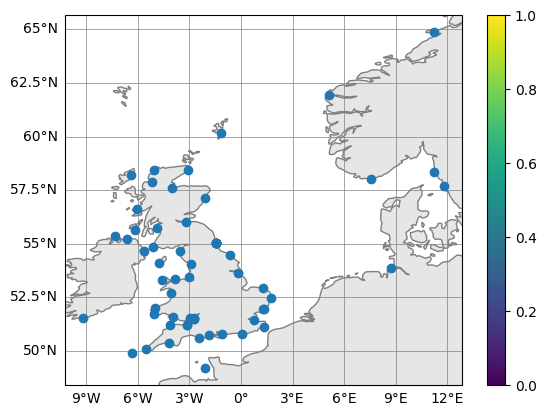

In [9]:
fig, ax = obs.plot_on_map()

There is also a slightly expanded version where you can plot multiple tidegauge objects, included as a list, and also the colour (if it is a dataarray with one value per location).

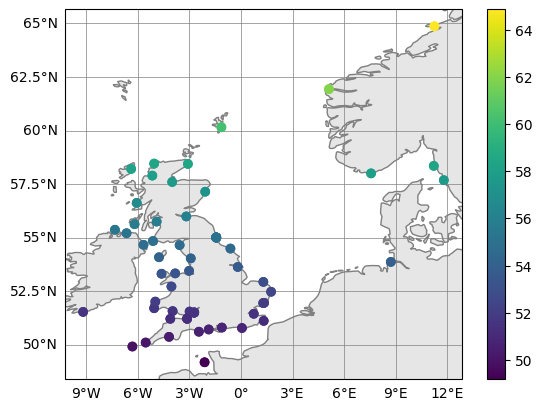

In [10]:
# plot a list tidegauge datasets (here repeating obs for the point of demonstration) and colour
fig, ax = obs.plot_on_map_multiple([obs,obs], color_var_str="latitude")

Time series can be plotted using `matplotlib.pyplot` methods. However `xarray` has its own plotting wrappers that can be used, which offers some conveniences with labelling

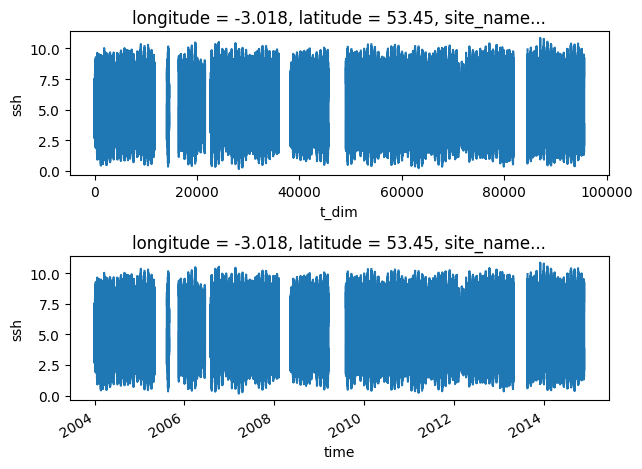

In [11]:
stn_id=26  # pick a gauge station

plt.subplot(2,1,1)
obs.dataset.ssh[stn_id].plot()  # rename time dimension to enable automatic x-axis labelling

plt.subplot(2,1,2)
obs.dataset.ssh[stn_id].swap_dims({'t_dim':'time'}).plot()  # rename time dimension to enable automatic x-axis labelling
plt.tight_layout()
plt.show()

Or you can use the `Tidegauge.plot_timeseries()` method, in which start and end dates can also be specified.

(<Figure size 1000x1000 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x7fd47c617d90>)

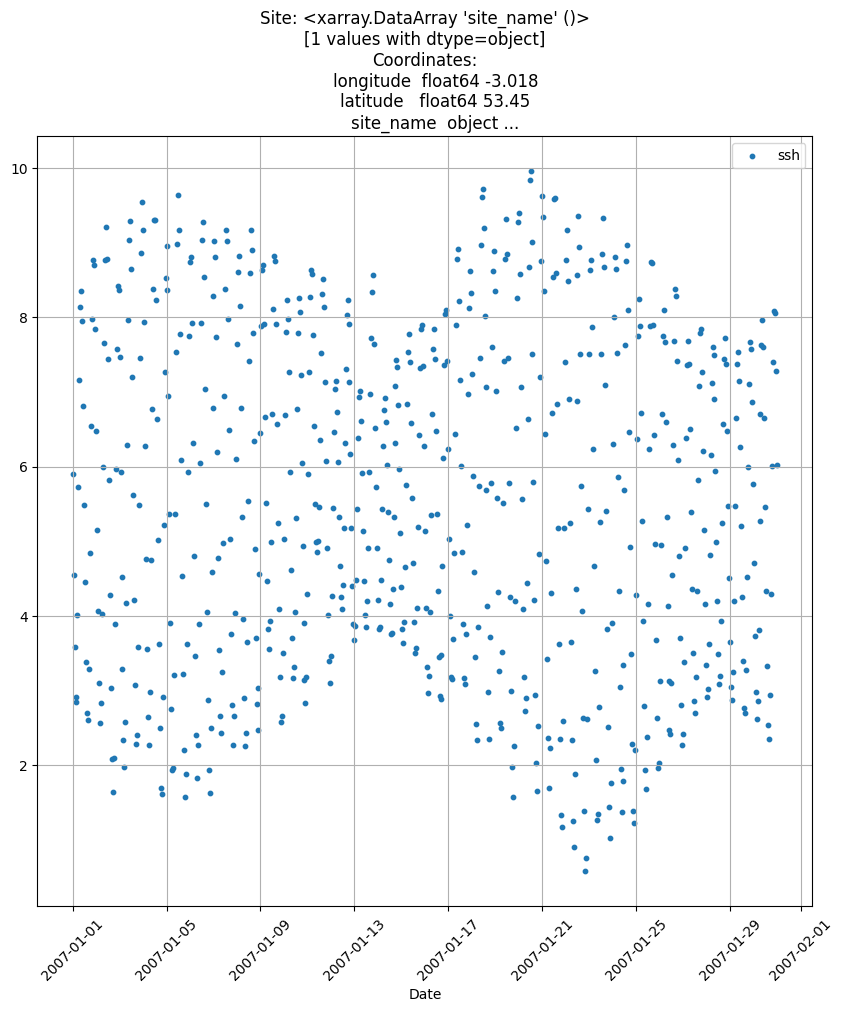

In [12]:
obs.isel(id_dim=stn_id).plot_timeseries(date_start=np.datetime64('2007-01-01'),
                                        date_end = np.datetime64('2007-01-31') )

## Basic manipulation: subsetting + plotting



We can do some simple spatial and temporal manipulations of this data:


Tidegauge object at 0x7fd50df9da00 initialised
Tidegauge object at 0x7fd50df9da00 initialised
Tidegauge object at 0x7fd50df9da00 initialised


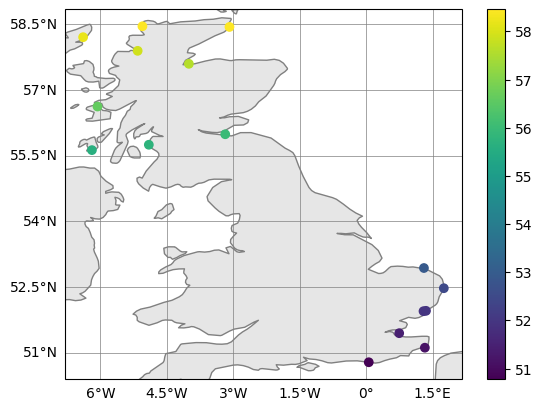

In [13]:
# Cut out a time window
obs_cut = obs.time_slice( date0 = datetime.datetime(2007, 1, 1), date1 = datetime.datetime(2007,1,31))

# Cut out geographical boxes
obs_upper = obs_cut.subset_indices_lonlat_box(lonbounds = [0, 3],
                                            latbounds = [50, 55])
obs_lower = obs_cut.subset_indices_lonlat_box(lonbounds = [-9, -3],
                                            latbounds = [55.5, 59])

#fig, ax = obs_cut.plot_on_map()
fig, ax = obs_upper.plot_on_map_multiple([obs_upper, obs_lower], color_var_str="latitude")

### Gridded model comparison

To compare our observations to the model, we will interpolate a model variable to the same time and geographical space as the tidegauge. This is done using the `obs_operator()` method.

But first load some gridded data and manipulate some variable names for convenience

In [16]:
nemo = coast.Gridded(fn_dat, fn_dom, multiple=True, config=fn_config)
# Rename depth_0 to be depth
nemo.dataset = nemo.dataset.rename({"depth_0": "depth"})
#nemo.dataset = nemo.dataset[["ssh", "landmask"]]

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "time_counter" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.


interpolate model onto obs locations
```
tidegauge_from_model = obs.obs_operator(nemo, time_interp='nearest')
```

Doing this would create a new interpolated tidegauge called `tidegauge_from_model`
Take a look at `tidegauge_from_model.dataset` to see for yourself. If a `landmask`
variable is present in the `Gridded` dataset then the nearest wet points will
be taken. Otherwise, just the nearest point is taken. If `landmask` is required
but not present you will need to insert it into the dataset yourself. For nemo
data, you could use the `bottom_level` or `mbathy` variables to do this. E.g:


In [17]:
# Create a landmask array and put it into the nemo object.
# Here, using the bottom_level == 0 variable from the domain file is enough.
nemo.dataset["landmask"] = nemo.dataset.bottom_level == 0

# Then do the interpolation
tidegauge_from_model = obs.obs_operator(nemo, time_interp='nearest')

Calculating spatial indices.
Calculating time indices.
 Indexing model data at tide gauge locations.. 
Calculating interpolation distances.
Interpolating in time...
Tidegauge object at 0x7fd50df9da00 initialised


However, the new `tidegauge_from_model` will the same number of time entries as the `obs` data, rather than the model data (so this will include lots of empty values). So, for a more useful demonstration we trim the observed gauge data so it better matches the model data.

In [18]:
# Cut down data to be only in 2007 to match model data.
start_date = datetime.datetime(2007, 1, 1)
end_date = datetime.datetime(2007, 1, 31)
obs = obs.time_slice(start_date, end_date)

Tidegauge object at 0x7fd50df9da00 initialised


### Interpolate model data onto obs locations

In [19]:
model_timeseries = obs.obs_operator(nemo)

# Take a look
model_timeseries.dataset

Calculating spatial indices.
Calculating time indices.
 Indexing model data at tide gauge locations.. 
Calculating interpolation distances.
Interpolating in time...
Tidegauge object at 0x7fd50df9da00 initialised


<xarray.Dataset>
Dimensions:        (z_dim: 51, axis_nbounds: 2, t_dim: 720, id_dim: 61)
Coordinates:
    longitude      (id_dim) float32 1.444 -4.0 -5.333 ... 7.666 -9.111 8.777
    latitude       (id_dim) float32 51.93 51.53 58.0 51.67 ... 58.0 51.53 53.87
    depth          (z_dim, id_dim) float32 0.1001 0.2183 0.2529 ... 27.32 10.11
  * time           (t_dim) datetime64[ns] 2007-01-01 ... 2007-01-30T23:00:00
Dimensions without coordinates: z_dim, axis_nbounds, t_dim, id_dim
Data variables:
    deptht_bounds  (z_dim, axis_nbounds) float32 0.0 6.157 ... 5.924e+03
    ssh            (t_dim, id_dim) float32 nan nan nan ... 0.3721 -0.0752 0.7412
    temperature    (t_dim, z_dim, id_dim) float32 nan nan nan ... nan nan nan
    bathymetry     (id_dim) float32 10.0 21.81 6.075 15.56 ... 17.8 14.06 10.0
    e1             (id_dim) float32 7.618e+03 7.686e+03 ... 7.686e+03 7.285e+03
    e2             (id_dim) float32 7.414e+03 7.414e+03 ... 7.414e+03 7.414e+03
    e3_0           (z_dim, id_dim) float32 0.2002 0.4365 0.5059 ... 0.541 0.2002
    bottom_level   (id_dim) float32 50.0 50.0 12.0 32.0 ... 44.0 17.0 26.0 50.0
    landmask       (id_dim) bool False False False False ... False False False
    interp_dist    (id_dim) float64 10.56 4.33 15.65 6.018 ... 5.835 4.96 3.957
Attributes:
    name:         AMM7_1d_20070101_20070131_25hourm_grid_T
    description:  ocean T grid variables, 25h meaned
    title:        ocean T grid variables, 25h meaned
    Conventions:  CF-1.6
    timeStamp:    2019-Dec-26 04:35:28 GMT
    uuid:         96cae459-d3a1-4f4f-b82b-9259179f95f7
    history:      Tue May 19 12:07:51 2020: ncks -v votemper,sossheig -d time...
    NCO:          4.4.7

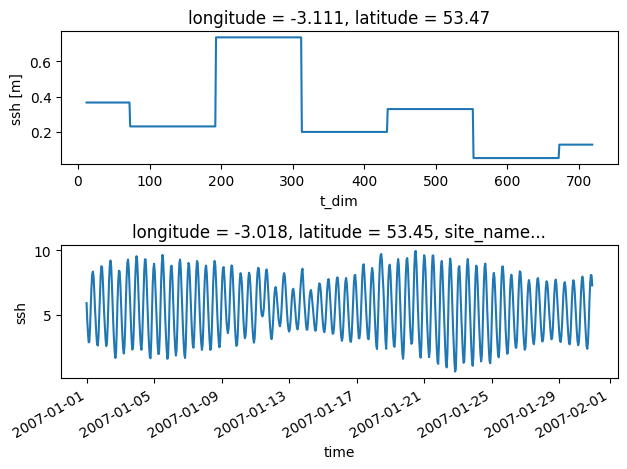

In [20]:
stn_id=26  # pick a gauge station

plt.subplot(2,1,1)
model_timeseries.dataset.ssh.isel(id_dim=stn_id).plot()  # rename time dimension to enable automatic x-axis labelling

plt.subplot(2,1,2)
obs.dataset.ssh.isel(id_dim=stn_id).swap_dims({'t_dim':'time'}).plot()  # rename time dimension to enable automatic x-axis labelling
plt.tight_layout()
plt.show()

We can see that the structure for the new dataset `model_timeseries`, generated from the gridded model simulation, is that of a `tidegauge` object. NB in the example simulation data the ssh variable is output as 5-day means. So it is not particulatly useful for high frequency validation but serves as a demonstration of the workflow.

## Tidegauge analysis methods

For a good comparison, we would like to make sure that both the observed and
modelled `Tidegauge` objects contain the same missing values. `TidegaugeAnalysis`
contains a routine for ensuring this. First create our analysis object:

In [21]:
tganalysis = coast.TidegaugeAnalysis()

In [22]:
# This routine searches for missing values in each dataset and applies them
# equally to each corresponding dataset
obs_new, model_new = tganalysis.match_missing_values(obs.dataset.ssh, model_timeseries.dataset.ssh)

Tidegauge object at 0x7fd50df9da00 initialised
Tidegauge object at 0x7fd50df9da00 initialised


Although we input data arrays to the above routine, it returns two new Tidegauge objects. Now you have equivalent and comparable sets of time series that can be easily compared.

### Harmonic Analysis & Non tidal-Residuals

The `Tidegauge` object contains some routines which make harmonic analysis and
the calculation/comparison of non-tidal residuals easier. Harmonic analysis is
done using the `utide` package. Please see [here](https://pypi.org/project/UTide/) for more info.

First we can use the `TidegaugeAnalysis` class to do a harmonic analysis. Suppose
we have two `Tidegauge` objects called `obs` and `model_timeseries` generated from tidegauge observations and model simulations respectively.

Then subtract means from all the time series

In [23]:
# Subtract means from all time series
obs_new = tganalysis.demean_timeseries(obs_new.dataset)
model_new = tganalysis.demean_timeseries(model_new.dataset)

# Now you have equivalent and comparable sets of time series that can be
# easily compared.

Tidegauge object at 0x7fd50df9da00 initialised
Tidegauge object at 0x7fd50df9da00 initialised


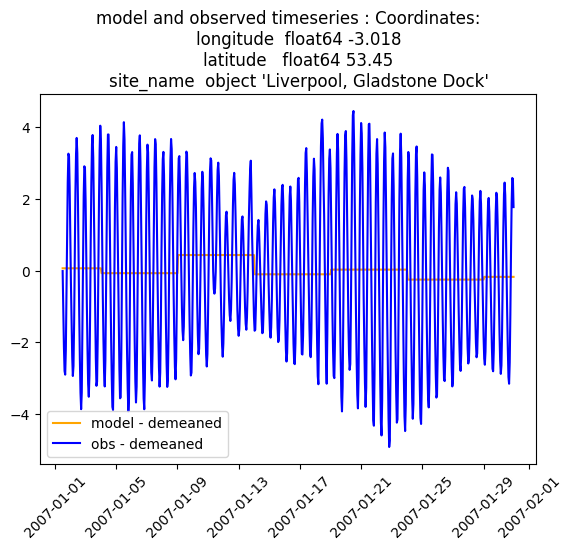

In [24]:
plt.figure()
plt.plot( model_new.dataset.time, model_new.dataset.ssh.isel(id_dim=stn_id),
         label='model - demeaned', color='orange' )
plt.plot( obs_new.dataset.time, obs_new.dataset.ssh.isel(id_dim=stn_id) ,
         label='obs - demeaned', color='blue' )
plt.title(f'model and observed timeseries : {obs_new.dataset.site_name.isel(id_dim=stn_id).coords}')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Then we can apply the harmonic analysis (though the example data is too short for this example to be that meaningful and the model data is only saved as 5-day means! Nevertheless we proceed):

### Calculate non tidal residuals



First, do a harmonic analysis. This routine uses utide

In [25]:
ha_mod = tganalysis.harmonic_analysis_utide(model_new.dataset.ssh, min_datapoints=1)
ha_obs = tganalysis.harmonic_analysis_utide(obs_new.dataset.ssh, min_datapoints=1)

solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.


/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: 

/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.


/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.
solve: matrix prep ... solution ... done.


/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.12/envs/coast-10/lib/python3.10/site-packages/utide/confidence.py:244: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/mnt/code/.pyenv/versions/3.10.

The `harmonic_analysis_utide` routine returns a list of `utide` structure object,
one for each `id_dim` in the `Tidegauge` object. It can be passed any of the
arguments that go to `utide`. It also has an additional argument `min_datapoints`
which determines a minimum number of data points for the harmonics analysis.
If a tidegauge `id_dim` has less than this number, it will not return an analysis.

Now, create new `TidegaugeMultiple` objects containing reconstructed tides:


In [26]:
tide_mod = tganalysis.reconstruct_tide_utide(model_new.dataset.time, ha_mod)
tide_obs = tganalysis.reconstruct_tide_utide(obs_new.dataset.time, ha_obs)


prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ... done.
prep/calcs ..

Get new TidegaugeMultiple objects containing non tidal residuals:

In [27]:
ntr_mod = tganalysis.calculate_non_tidal_residuals(model_new.dataset.ssh, tide_mod.dataset.reconstructed, apply_filter=False)
ntr_obs = tganalysis.calculate_non_tidal_residuals(obs_new.dataset.ssh, tide_obs.dataset.reconstructed, apply_filter=True, window_length=10, polyorder=2)

# Take a look
ntr_obs.dataset

Tidegauge object at 0x7fd50df9da00 initialised
Tidegauge object at 0x7fd50df9da00 initialised


<xarray.Dataset>
Dimensions:    (t_dim: 720, id_dim: 61)
Coordinates:
    time       (t_dim) datetime64[ns] 2007-01-01 ... 2007-01-30T23:00:00
    longitude  (id_dim) float64 1.292 -3.975 -5.158 -5.051 ... 7.567 350.8 8.717
    latitude   (id_dim) float64 51.95 51.57 57.9 51.71 ... 58.0 51.53 53.87
    site_name  (id_dim) object 'Harwich' 'Mumbles' 'Ullapool' ... 'N/A' 'N/A'
Dimensions without coordinates: t_dim, id_dim
Data variables:
    ntr        (id_dim, t_dim) float64 0.4182 0.4182 0.4182 ... -0.02699 0.2945

The dataset structure is preserved and has created a new variable called `ntr` - non-tidal residual.

By default, this routines will apply `scipy.signal.savgol_filter` to the non-tidal residuals
to remove some noise. This can be switched off using `apply_filter = False`.

The Doodson X0 filter is an alternative way of estimating non-tidal residuals. This will return a new Tidegauge() object containing filtered ssh data:

In [28]:
dx0 = tganalysis.doodson_x0_filter(obs_new.dataset, "ssh")

# take a look
dx0.dataset


Tidegauge object at 0x7fd50df9da00 initialised


<xarray.Dataset>
Dimensions:    (t_dim: 720, id_dim: 61)
Coordinates:
    longitude  (id_dim) float64 1.292 -3.975 -5.158 -5.051 ... 7.567 350.8 8.717
    latitude   (id_dim) float64 51.95 51.57 57.9 51.71 ... 58.0 51.53 53.87
    site_name  (id_dim) object 'Harwich' 'Mumbles' 'Ullapool' ... 'N/A' 'N/A'
Dimensions without coordinates: t_dim, id_dim
Data variables:
    time       (t_dim) datetime64[ns] 2007-01-01 ... 2007-01-30T23:00:00
    ssh        (id_dim, t_dim) float64 nan nan nan nan nan ... nan nan nan nan

We can compare these analyses e.g. the observed timeseries against the harmonic reconstruction. Noting we can in principle extend the harmoninc reconstruction beyond the observation time window.

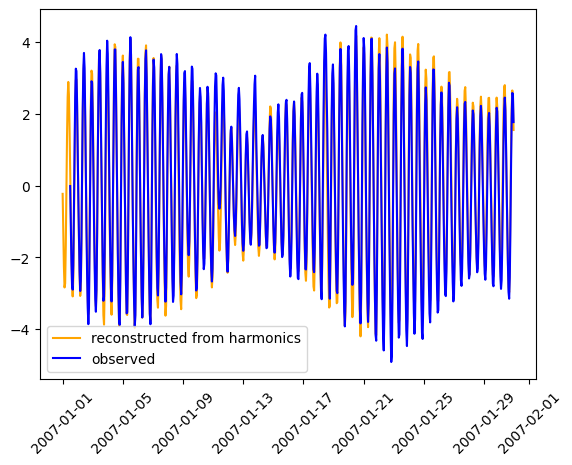

In [29]:
plt.figure()
plt.plot( tide_obs.dataset.time, tide_obs.dataset.reconstructed.isel(id_dim=stn_id), label='reconstructed from harmonics', color='orange' )
plt.plot( obs_new.dataset.time, obs_new.dataset.ssh.isel(id_dim=stn_id) , label='observed', color='blue' )
plt.legend()
plt.xticks(rotation=45)
plt.show()

We can also look closer at the difference between the observed timeseries and the harmonic reconstruction, that is the non-tidal residual. And we can compare the observed and modelled non-harmonic residual and contrast the different methods of removing the tides. Here we contrast using a harmonic analysis (and creating a "non-tidal residual") with the DoodsonX0 filter. Note that the timeseries is far too short for a sensible analysis and that this is really a demonstration of concept.

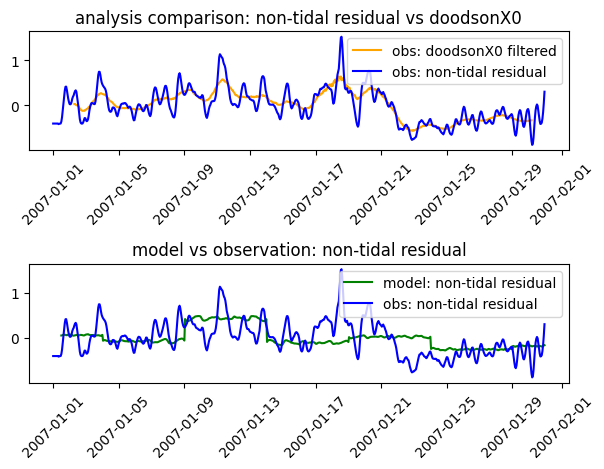

In [30]:
plt.figure()
plt.subplot(2,1,1)
plt.plot( dx0.dataset.time, dx0.isel(id_dim=stn_id).dataset.ssh, label='obs: doodsonX0 filtered', color='orange' )
plt.plot( ntr_obs.dataset.time, ntr_obs.isel(id_dim=stn_id).dataset.ntr, label='obs: non-tidal residual', color='blue' )
plt.title('analysis comparison: non-tidal residual vs doodsonX0')
plt.legend()
plt.xticks(rotation=45)

plt.subplot(2,1,2)
plt.plot( ntr_mod.dataset.time, ntr_mod.isel(id_dim=stn_id).dataset.ntr, label='model: non-tidal residual', color='g' )
plt.plot( ntr_obs.dataset.time, ntr_obs.isel(id_dim=stn_id).dataset.ntr, label='obs: non-tidal residual', color='blue' )
plt.title('model vs observation: non-tidal residual')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()


### Threshold Statistics for non-tidal residuals

This is a simple extreme value analysis of whatever data you use. It will count the number of peaks and the total time spent over each threshold provided. It will also count the numbers of daily and monthly maxima over each threshold. To this, a Tidegauge object and an array of thresholds (in metres) should be passed. The method return `peak_count_*`, `time_over_threshold_*`, `dailymax_count_*`, `monthlymax_count_*`:


In [31]:
thresh_mod = tganalysis.threshold_statistics(ntr_mod.dataset, thresholds=np.arange(-2, 2, 0.1))
thresh_obs = tganalysis.threshold_statistics(ntr_obs.dataset, thresholds=np.arange(-2, 2, 0.1))

In [32]:
# Have a look
thresh_obs

<xarray.Dataset>
Dimensions:                  (t_dim: 720, id_dim: 61, threshold: 40)
Coordinates:
    longitude                (id_dim) float64 1.292 -3.975 ... 350.8 8.717
    latitude                 (id_dim) float64 51.95 51.57 57.9 ... 51.53 53.87
    site_name                (id_dim) object 'Harwich' 'Mumbles' ... 'N/A' 'N/A'
  * threshold                (threshold) float64 -2.0 -1.9 -1.8 ... 1.7 1.8 1.9
Dimensions without coordinates: t_dim, id_dim
Data variables:
    time                     (t_dim) datetime64[ns] 2007-01-01 ... 2007-01-30...
    peak_count_ntr           (id_dim, threshold) float64 40.0 40.0 ... 2.0 1.0
    time_over_threshold_ntr  (id_dim, threshold) float64 720.0 720.0 ... 5.0 4.0
    dailymax_count_ntr       (id_dim, threshold) float64 30.0 30.0 ... 2.0 1.0
    monthlymax_count_ntr     (id_dim, threshold) float64 1.0 1.0 1.0 ... 1.0 1.0

Text(0, 0.5, 'event count')

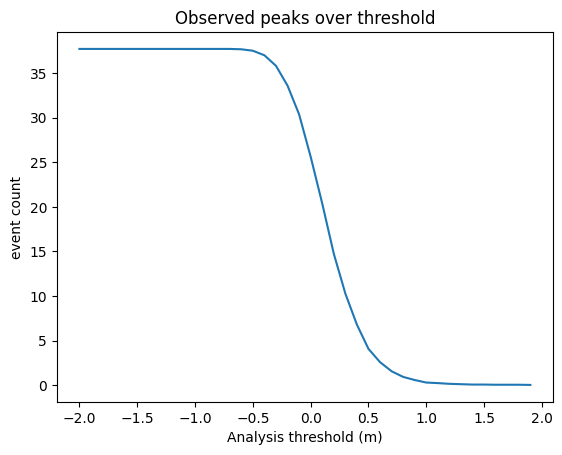

In [33]:
plt.plot( thresh_obs.threshold, thresh_obs.peak_count_ntr.mean(dim='id_dim') )
#plt.ylim([0,15])
plt.title(f"Observed peaks over threshold")
plt.xlabel('Analysis threshold (m)')
plt.ylabel('event count')

Note that the non-tidal residual is a noisy timeseries (computed as a difference between two timeseries) so peaks do not necessarily correspond to peaks in total water level. For this reason `time_over_threshold_*` can be useful. Below we see that about 28% (y-axis) of the observations of non-tidal residual exceed 20cm (x-axis). Again, threshold statistics are more useful with a longer record.

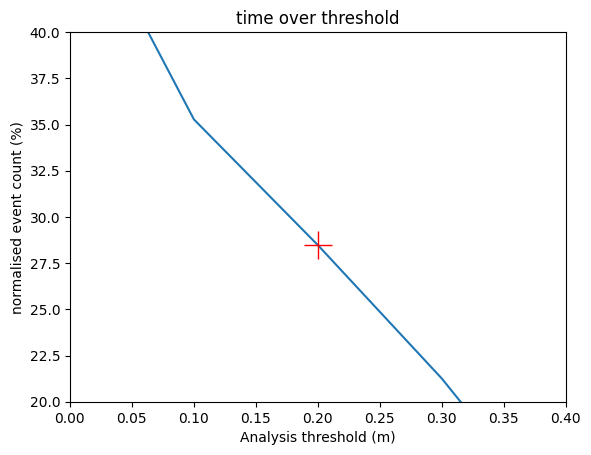

In [34]:
normalised_event_count = 100 * thresh_obs.time_over_threshold_ntr.isel(id_dim=stn_id) / thresh_obs.time_over_threshold_ntr.isel(id_dim=stn_id).max()

plt.plot( thresh_obs.threshold, normalised_event_count )
plt.ylim([20,40])
plt.xlim([0.0,0.4])
plt.title(f"time over threshold")
plt.xlabel('Analysis threshold (m)')
plt.ylabel('normalised event count (%)')
plt.plot(thresh_obs.threshold[22], normalised_event_count[22], 'r+', markersize=20)


## Other TidegaugeAnalysis methods 

### Calculate errors

The difference() routine will calculate differences, absolute_differences and squared differenced for all variables. Corresponding new variables are created with names `diff_*`, `abs_diff_*` and `square_diff_*`

In [35]:
ntr_diff = tganalysis.difference(ntr_obs.dataset, ntr_mod.dataset)
ssh_diff = tganalysis.difference(obs_new.dataset, model_new.dataset)

# Take a look
ntr_diff.dataset

Tidegauge object at 0x7fd50df9da00 initialised
Tidegauge object at 0x7fd50df9da00 initialised


<xarray.Dataset>
Dimensions:          (t_dim: 720, id_dim: 61)
Coordinates:
  * time             (t_dim) datetime64[ns] 2007-01-01 ... 2007-01-30T23:00:00
    site_name        (id_dim) object 'Harwich' 'Mumbles' ... 'N/A' 'N/A'
    longitude        (id_dim) float64 1.292 -3.975 -5.158 ... 7.567 350.8 8.717
    latitude         (id_dim) float64 51.95 51.57 57.9 ... 58.0 51.53 53.87
Dimensions without coordinates: t_dim, id_dim
Data variables:
    diff_ntr         (id_dim, t_dim) float64 nan nan nan ... 0.05885 0.3435
    abs_diff_ntr     (id_dim, t_dim) float64 nan nan nan ... 0.05885 0.3435
    square_diff_ntr  (id_dim, t_dim) float64 nan nan nan ... 0.003464 0.118

We can then easily get mean errors, MAE and MSE


In [36]:
mean_stats = ntr_diff.dataset.mean(dim="t_dim", skipna=True)